# Time Series Final Project Notebook
Napoleon Vuong

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

import warnings                               
warnings.filterwarnings('ignore')

## Filtering columns to only include Datetime and Active Power and aggregating datetime to be on a daily basis
Group dates by the day and sum up the "Active Power" column for each day to get daily active power for daily forecasting

In [2]:
df = pd.read_csv("train_imputed (2).csv")
df = df[['Datetime', 'ActivePower']]
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = df['Datetime'].dt.date
df_daily = df[['Date', 'ActivePower']].groupby('Date').sum().reset_index().sort_values('Date')
df_daily

,Date,ActivePower
0,2018-01-01,24178.923956
1,2018-01-02,40070.788083
2,2018-01-03,40129.409441
3,2018-01-04,47287.251399
4,2018-01-05,30015.577400
...,...,...
728,2020-03-11,45696.346270
729,2020-03-12,51328.398473
730,2020-03-13,83651.039923
731,2020-03-14,97638.164507


## Filtering columns to only include Datetime and Active Power and aggregating datetime to be on a daily basis
Group dates by the day and sum up the "Active Power" column for each day to get daily active power for daily forecasting

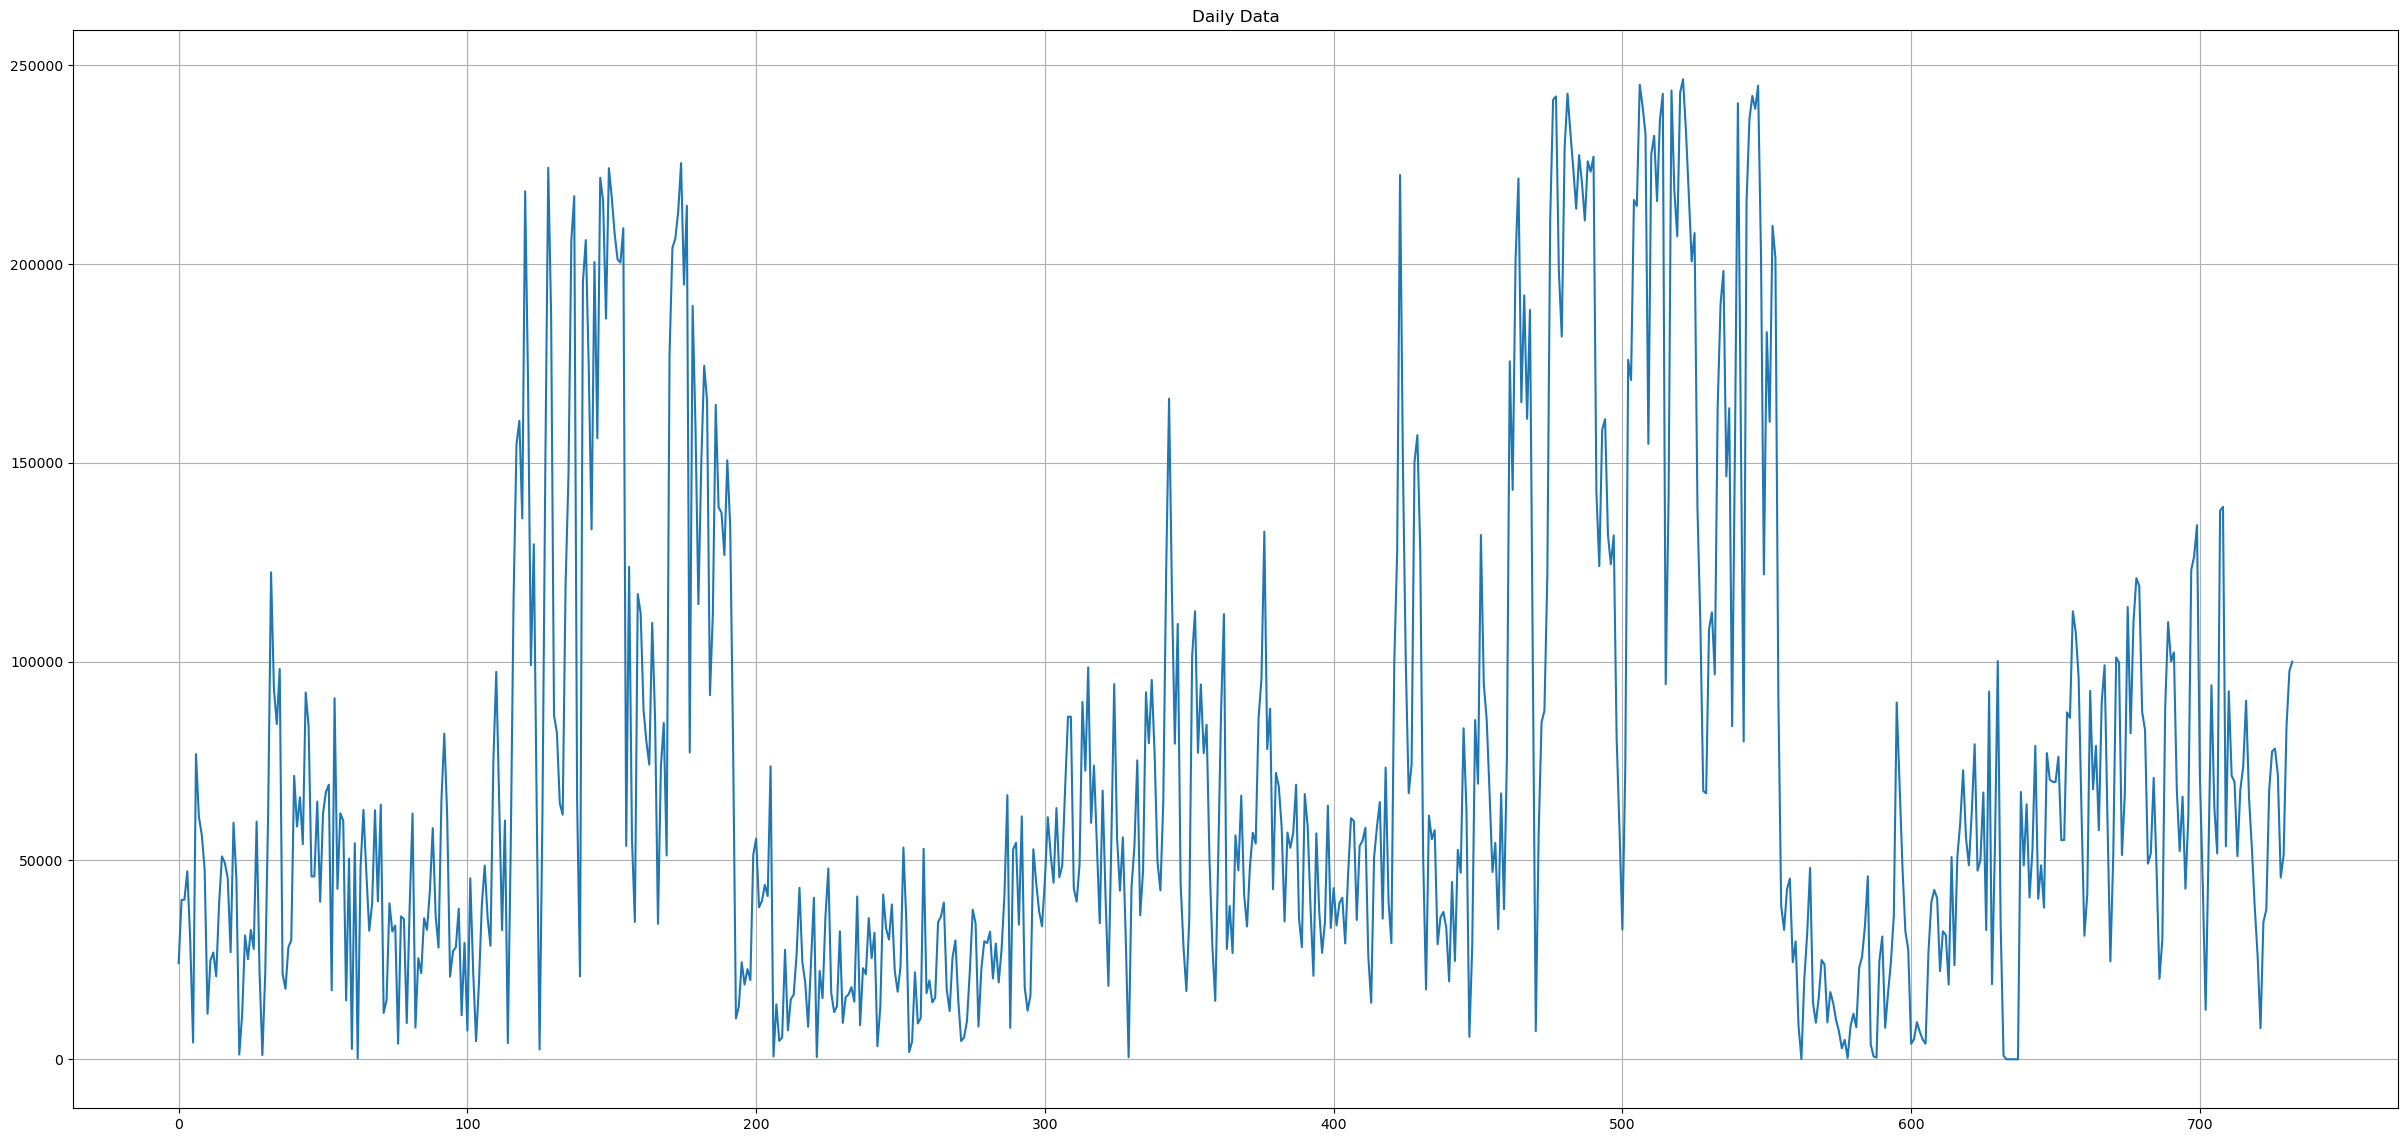

In [3]:
plt.figure(figsize=(30, 14))
plt.plot(df_daily.ActivePower)
plt.title('Daily Data')
plt.grid(True)
plt.show()

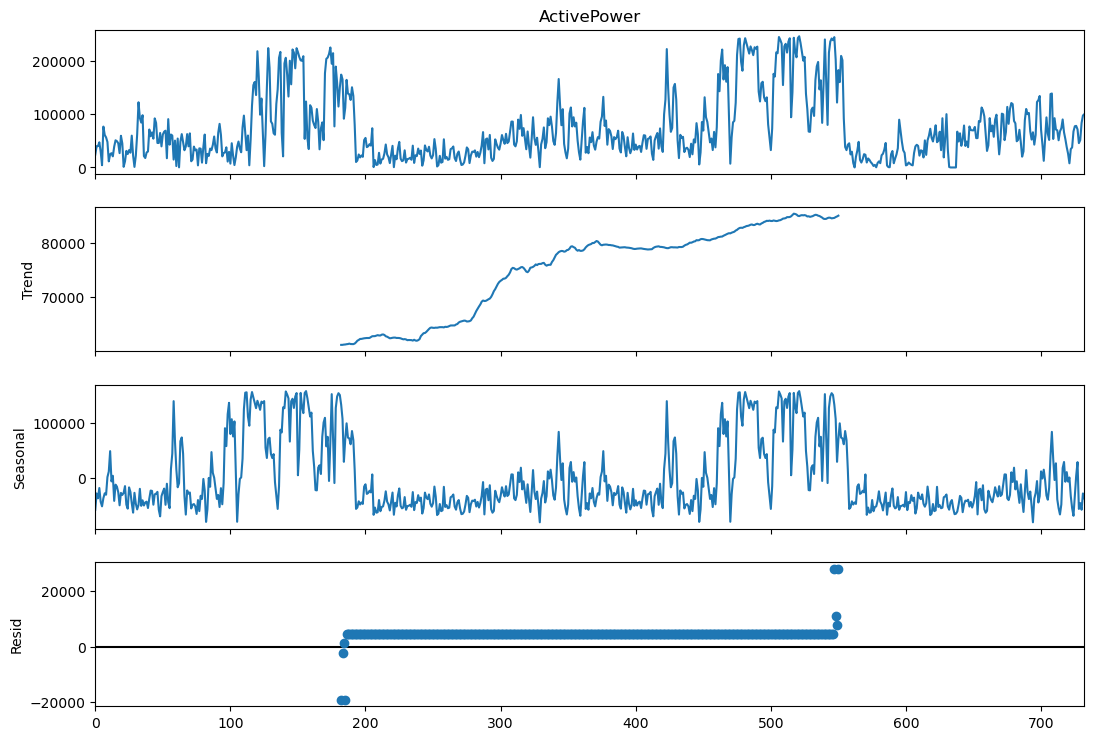

In [4]:
res = sm.tsa.seasonal_decompose(df_daily["ActivePower"],period=365,model="additive")
# res = sm.tsa.seasonal_decompose(df_daily["ActivePower"],period=365,model="multiplicative")
fig = res.plot()
fig.set_size_inches(12, 8)

In [5]:
# Convert to time series format
df_daily.set_index("Date", inplace=True)
ts_data = df_daily["ActivePower"]

# Define parameter grid
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 1)
D_values = range(0, 1)
Q_values = range(0, 1)
s = 365  # Seasonal cycle (yearly seasonality)
validation_size = 15  # Validation set size in cross-validation
K_folds = 1

# Best model tracking
best_rmse, best_order, best_seasonal = float("inf"), None, None
results = []

# Grid Search
for order in itertools.product(p_values, d_values, q_values):
    for seasonal_order in itertools.product(P_values, D_values, Q_values):
        seasonal = (seasonal_order[0], seasonal_order[1], seasonal_order[2], s)
        rmse_total = 0

        # Rolling Cross-Validation (3-fold)
        train_size = len(ts_data) - K_folds * validation_size
        for k in range(K_folds):
            train = ts_data[: train_size + k * validation_size]
            test = ts_data[train_size + k * validation_size: train_size + k * validation_size + validation_size]

            try:
                model = SARIMAX(train, order=order, seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                predictions = model_fit.forecast(steps=len(test))
                rmse_total += np.sqrt(mean_squared_error(test, predictions))
            except:
                rmse_total += float("inf")

        avg_rmse = rmse_total / K_folds  # Average RMSE over folds
        results.append((order, seasonal, avg_rmse))

        # Keep track of the best model
        if avg_rmse < best_rmse:
            best_rmse, best_order, best_seasonal = avg_rmse, order, seasonal

        print(f"SARIMA{order} x {seasonal} RMSE={avg_rmse:.3f}")

# Print Best Model
print(f"\nBest SARIMA Model: ARIMA{best_order} x Seasonal{best_seasonal} with RMSE={best_rmse:.3f}")

SARIMA(0, 0, 0) x (0, 0, 0, 365) RMSE=63601.301
SARIMA(0, 0, 1) x (0, 0, 0, 365) RMSE=63258.765
SARIMA(0, 1, 0) x (0, 0, 0, 365) RMSE=27238.147
SARIMA(0, 1, 1) x (0, 0, 0, 365) RMSE=29129.532
SARIMA(1, 0, 0) x (0, 0, 0, 365) RMSE=39684.089
SARIMA(1, 0, 1) x (0, 0, 0, 365) RMSE=33896.214
SARIMA(1, 1, 0) x (0, 0, 0, 365) RMSE=28277.769
SARIMA(1, 1, 1) x (0, 0, 0, 365) RMSE=29685.033

Best SARIMA Model: ARIMA(0, 1, 0) x Seasonal(0, 0, 0, 365) with RMSE=27238.147


In [8]:
# Fit the best model on the full dataset
best_model = SARIMAX(
    ts_data, order=best_order, seasonal_order=best_seasonal,
    enforce_stationarity=False, enforce_invertibility=False
)
best_model_fit = best_model.fit(disp=False)

# Forecast the next 15 days
forecast_steps = 15
forecast_dates = pd.date_range(start=ts_data.index[-1], periods=forecast_steps + 1, freq='D')[1:]
forecast_values = best_model_fit.forecast(steps=forecast_steps)

# Create DataFrame in the correct format
forecast_df = pd.DataFrame({"Date": forecast_dates, "Forecasting": forecast_values})

# Save the cleaned forecast (No placeholder rows)
forecast_df.to_csv("forecast_15_days_NV_ARIMA.csv", index=False)

print("\nForecast saved as 'forecast_15_days_NV_ARIMA.csv'")


Forecast saved as 'forecast_15_days_NV_ARIMA.csv'
